In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-07-13 00:29:26--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.198.168, 52.217.79.54, 52.217.110.38, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.198.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.6MB/s    in 0.7s    

2023-07-13 00:29:27 (18.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

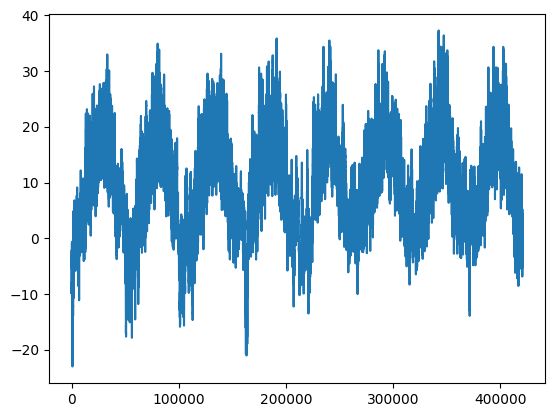

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

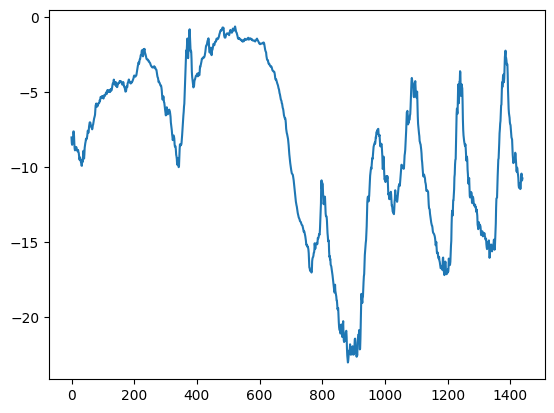

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis = 0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis = 0)
raw_data /= std

In [8]:
from tensorflow import keras

int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2,
)

for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
    shuffle = True,
    batch_size = batch_size,
    start_index = num_train_samples + num_val_samples
)

In [10]:
for samples, targets in train_dataset:
  print("샘플 크기 : ", samples.shape)
  print("타깃 크기 : ", targets.shape)
  break

샘플 크기 :  (256, 120, 14)
타깃 크기 :  (256,)


In [11]:
from tensorflow.keras import layers

inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = "relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only = True)
]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]: .2f}")

Epoch 1/10
819/819 [==============================] - 92s 110ms/step - loss: 16.0612 - mae: 3.0661 - val_loss: 10.8222 - val_mae: 2.5944
Epoch 2/10
819/819 [==============================] - 61s 75ms/step - loss: 10.0045 - mae: 2.4874 - val_loss: 11.3059 - val_mae: 2.6522
Epoch 3/10
819/819 [==============================] - 87s 106ms/step - loss: 9.2203 - mae: 2.3826 - val_loss: 11.2876 - val_mae: 2.6585
Epoch 4/10
819/819 [==============================] - 72s 88ms/step - loss: 8.6321 - mae: 2.3045 - val_loss: 10.8020 - val_mae: 2.5947
Epoch 5/10
819/819 [==============================] - 77s 93ms/step - loss: 8.2422 - mae: 2.2532 - val_loss: 10.1625 - val_mae: 2.5124
Epoch 6/10
819/819 [==============================] - 83s 101ms/step - loss: 7.9261 - mae: 2.2080 - val_loss: 10.4856 - val_mae: 2.5562
Epoch 7/10
819/819 [==============================] - 74s 89ms/step - loss: 7.6259 - mae: 2.1682 - val_loss: 10.2296 - val_mae: 2.5205
Epoch 8/10
819/819 [==============================

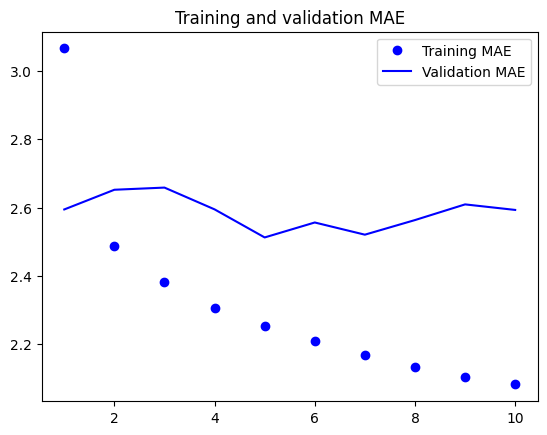

In [12]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label = "Training MAE")
plt.plot(epochs, val_loss, "b", label = "Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

In [13]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation = "relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8,12, activation = "relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation = "relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only = True)
]

model.compile(optimizer = "rmsprop", loss = "mse", metrics = ["mae"])
history = model.fit(train_dataset,
                    epochs = 10,
                    validation_data = val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE : {model.evaluate(test_dataset)[1]: .2f}")

Epoch 1/10
819/819 [==============================] - 91s 109ms/step - loss: 24.7409 - mae: 3.8462 - val_loss: 16.0088 - val_mae: 3.1366
Epoch 2/10
819/819 [==============================] - 88s 107ms/step - loss: 17.4249 - mae: 3.2824 - val_loss: 14.3922 - val_mae: 2.9933
Epoch 3/10
819/819 [==============================] - 89s 108ms/step - loss: 14.8538 - mae: 3.0602 - val_loss: 16.3312 - val_mae: 3.1462
Epoch 4/10
819/819 [==============================] - 91s 110ms/step - loss: 13.8733 - mae: 2.9533 - val_loss: 15.1866 - val_mae: 3.0730
Epoch 5/10
819/819 [==============================] - 87s 106ms/step - loss: 13.1913 - mae: 2.8781 - val_loss: 13.9575 - val_mae: 2.9723
Epoch 6/10
819/819 [==============================] - 87s 106ms/step - loss: 12.6456 - mae: 2.8132 - val_loss: 14.3868 - val_mae: 2.9729
Epoch 7/10
819/819 [==============================] - 87s 106ms/step - loss: 12.1965 - mae: 2.7628 - val_loss: 15.0283 - val_mae: 3.1001
Epoch 8/10
819/819 [=====================

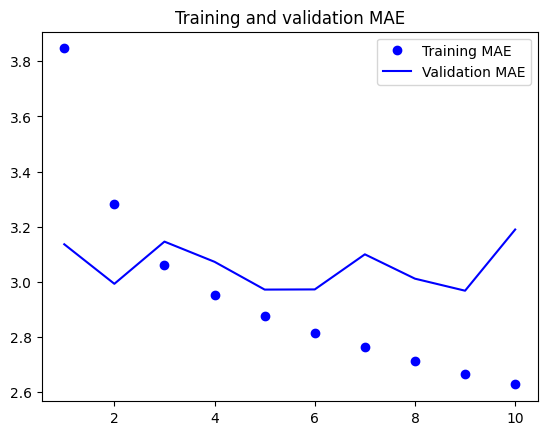

In [15]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 132s 158ms/step - loss: 39.5369 - mae: 4.5798 - val_loss: 12.4222 - val_mae: 2.6976
Epoch 2/10
819/819 [==============================] - 128s 156ms/step - loss: 11.0195 - mae: 2.5816 - val_loss: 9.9416 - val_mae: 2.4560
Epoch 3/10
819/819 [==============================] - 129s 157ms/step - loss: 9.9121 - mae: 2.4601 - val_loss: 9.8050 - val_mae: 2.4358
Epoch 4/10
819/819 [==============================] - 109s 132ms/step - loss: 9.5498 - mae: 2.4128 - val_loss: 9.7487 - val_mae: 2.4166
Epoch 5/10
819/819 [==============================] - 113s 138ms/step - loss: 9.2514 - mae: 2.3718 - val_loss: 9.7203 - val_mae: 2.4230
Epoch 6/10
819/819 [==============================] - 128s 156ms/step - loss: 8.9733 - mae: 2.3343 - val_loss: 9.7509 - val_mae: 2.4289
Epoch 7/10
819/819 [==============================] - 127s 155ms/step - loss: 8.7573 - mae: 2.3034 - val_loss: 9.8198 - val_mae: 2.4379
Epoch 8/10
819/819 [=========================

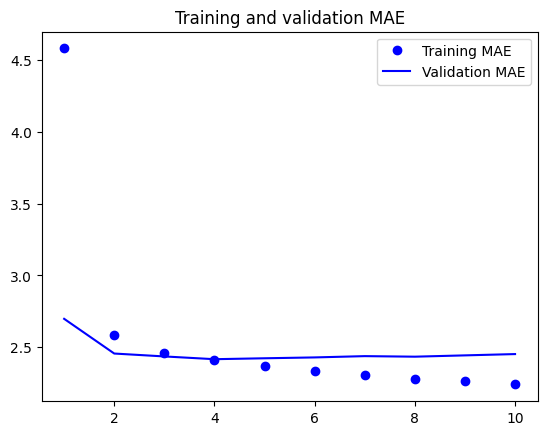

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [19]:
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, output_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis = 0)

ValueError: ignored

In [ ]:
num_features = 14
inputs = keras.INput(shape = None, num_features)
outputs = layers.SimpleRNN(16)(inputs)

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape = (steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = False)(inputs)
print(outputs.shape)

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape = (steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences = True)(inputs)
print(outputs.shape)

In [ ]:
inputs = keras.Input(shape = (steps, num_features))
x = layers.SimpleRNN(16, return_sequences = True)(inputs)
x = layers.simpleRNN(16, return_sequences = True)(x)
outputs = layers.SimpleRNN(16)(x)